##Notebook 3 : Finetuning Al-BERT

This series of notebooks demonstrates a comparative approach to fake news detection using natural language processing (NLP) techniques. We will use a dataset from Kaggle containing labeled news articles as real or fake.



### Ensuring TensorFlow Version 2.15
This code installs TensorFlow version 2.15.0 and tensorflow-text 2.15.0 using pip. This specific version might be required for compatibility with the code in this notebook. Errors during installation can be ignored.

In [1]:
!pip -q install tensorflow==2.15.0
!pip -q install tensorflow-text==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.67 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.6 MB/s eta 0:00:00


### Importing Necessary Libraries
This code imports the required libraries for data processing, model building, and visualization.

In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import tensorflow_text as text
import tensorflow_hub as hub
from keras.callbacks import ModelCheckpoint,EarlyStopping

import gdown
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


### Downloading the Preprocessed Dataset
This Code downloads the preprocessed dataset using `git clone`. The dataset is assumed to be processed in a previous notebook and is stored in a github repository.

In [3]:
!git clone https://github.com/starryendymion/ML-GP1-Monsoon-2024-SOEJNU
%cd 'ML-GP1-Monsoon-2024-SOEJNU'

Cloning into 'ML-GP1-Monsoon-2024-SOEJNU'...
remote: Enumerating objects: 16, done.
remote: Total 16 (delta 0), reused 0 (delta 0), pack-reused 16 (from 1)
Receiving objects: 100% (16/16), 91.95 MiB | 22.20 MiB/s, done.
/content/ML-GP1-Monsoon-2024-SOEJNU


### Loading Features and Labels
This code loads the features and labels from the downloaded dataset file (`data.npz`).  `features` likely contains the text data, and `labels` contains the corresponding target variables (e.g., sentiment labels).

In [5]:
loaded_data = np.load("processed_dataset/data.npz")
features=loaded_data["features"]
labels=loaded_data["labels"]

### Splitting and Shuffling the Dataset

This code splits the dataset into training and testing sets using `train_test_split` and then shuffles both sets using `shuffle` to ensure randomness.

In [6]:
x_train,x_test,y_train,y_test=train_test_split(features,labels,test_size=0.2)
x_train, y_train = shuffle(x_train,y_train, random_state=42)
x_test, y_test = shuffle(x_test,y_test, random_state=42)

### Loading Pre-trained ALBERT Layers

This code loads the ALBERT preprocessor and encoder from TensorFlow Hub. These layers will be used for text preprocessing and feature extraction.

In [7]:
albert_preprocess = hub.KerasLayer( "http://tfhub.dev/tensorflow/albert_en_preprocess/3")
albert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_base/3")

### Building the Model

This code defines the model architecture using the Keras functional API. It includes an input layer, preprocessing, encoding, and dense layers for classification.

In [8]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string,)
preprocessed_text = albert_preprocess(text_input)
encoded_text = albert_encoder(preprocessed_text)

Layer = tf.keras.layers.Dense(16, activation='relu')(encoded_text['pooled_output'])
Layer = tf.keras.layers.Dense(1, activation='sigmoid')(Layer)

model = tf.keras.Model(inputs=[text_input], outputs = [Layer])

### Model Summary

This Code prints a summary of the model, showing the layers, output shapes, and the number of parameters.

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['input_1[0][0]']             
                             128),                                                                
                              'input_word_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

### Defining Callbacks

This Code defines callbacks for early stopping and model checkpointing to monitor the training process and save the best model.

In [10]:
Earstop=EarlyStopping(monitor='val_accuracy',patience=5)
checkP=ModelCheckpoint('fintuned-albert_model.h5',monitor='val_accuracy',mode='max',verbose=1,save_best_only=True)

### Compiling the Model

This Code compiles the model, specifying the optimizer, loss function, and metrics for evaluation.

In [11]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

### Training the Model

This Code trains the model using the training data and evaluates it on the validation data. It also utilizes the defined callbacks.

In [12]:
history=model.fit(x_train,y_train,epochs=5,verbose=1,validation_data=(x_test,y_test),callbacks=[checkP,Earstop])

Epoch 1/5
139/140 [============================>.] - ETA: 0s - loss: 0.2060 - accuracy: 0.9321
Epoch 1: val_accuracy improved from -inf to 0.97484, saving model to fintuned-albert_model.h5
140/140 [==============================] - 71s 407ms/step - loss: 0.2060 - accuracy: 0.9321 - val_loss: 0.0951 - val_accuracy: 0.9748
Epoch 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


139/140 [============================>.] - ETA: 0s - loss: 0.0787 - accuracy: 0.9795
Epoch 2: val_accuracy improved from 0.97484 to 0.97934, saving model to fintuned-albert_model.h5
140/140 [==============================] - 56s 404ms/step - loss: 0.0787 - accuracy: 0.9795 - val_loss: 0.0729 - val_accuracy: 0.9793
Epoch 3/5
139/140 [============================>.] - ETA: 0s - loss: 0.0573 - accuracy: 0.9838
Epoch 3: val_accuracy improved from 0.97934 to 0.98113, saving model to fintuned-albert_model.h5
140/140 [==============================] - 65s 468ms/step - loss: 0.0573 - accuracy: 0.9838 - val_loss: 0.0500 - val_accuracy: 0.9811
Epoch 4/5
139/140 [============================>.] - ETA: 0s - loss: 0.0506 - accuracy: 0.9845
Epoch 4: val_accuracy improved from 0.98113 to 0.98293, saving model to fintuned-albert_model.h5
140/140 [==============================] - 66s 475ms/step - loss: 0.0505 - accuracy: 0.9845 - val_loss: 0.0421 - val_accuracy: 0.9829
Epoch 5/5
139/140 [=============

### Visualizing Training Results

This Code plots the training and validation accuracy and loss curves to visualize the model's performance during training.

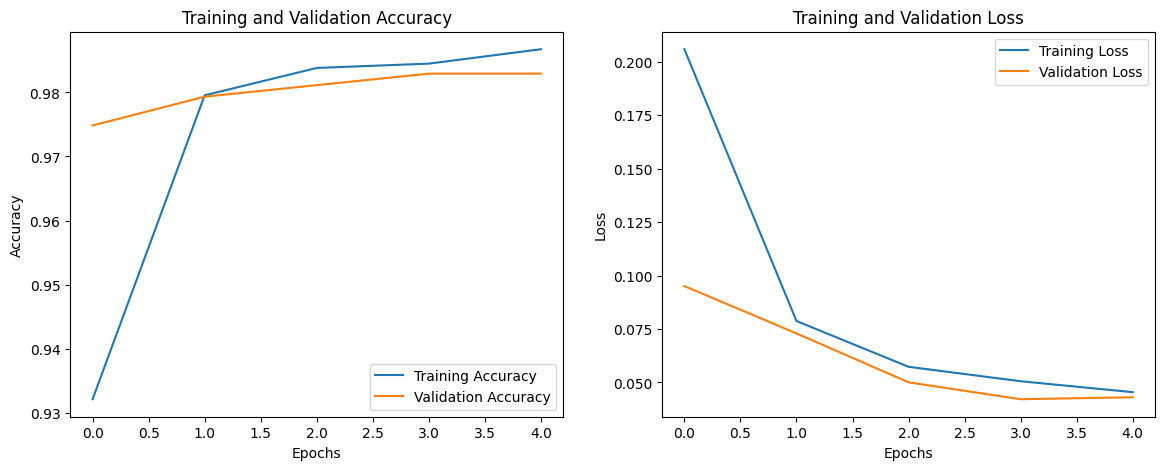

In [13]:
from matplotlib import pyplot as plt

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

35/35 [==============================] - 12s 327ms/step


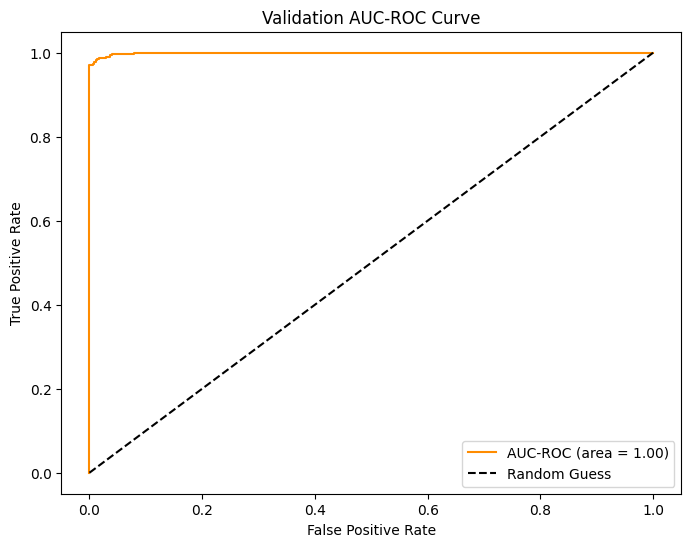

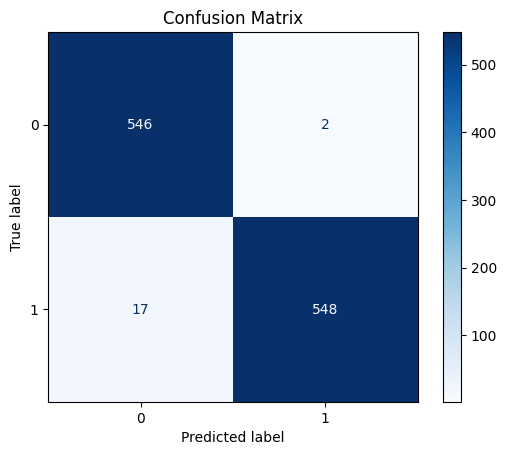

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Get model predictions for AUC-ROC curve
y_pred_proba = model.predict(x_test).ravel()
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

# Plotting the AUC-ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC-ROC (area = {auc_score:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation AUC-ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Get binary predictions for confusion matrix
y_pred_binary = (y_pred_proba >= 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()